In [1]:

import matplotlib.pyplot as plt
import torch
from muutils.dbg import dbg_auto

from spd.clustering.activations import component_activations, process_activations
from spd.clustering.merge import compute_merge_costs, merge_iteration
from spd.clustering.merge_matrix import GroupMerge
from spd.experiments.resid_mlp.resid_mlp_dataset import ResidualMLPDataset
from spd.models.component_model import ComponentModel
from spd.utils.data_utils import DatasetGeneratedDataLoader

DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
# magic autoreload
%load_ext autoreload
%autoreload 2

In [3]:
component_model, cfg, path = ComponentModel.from_pretrained("wandb:goodfire/spd/runs/dcjm9g2n")
component_model.to(DEVICE);
# dbg_auto(component_model)
# dbg_auto(cfg)
# dbg_auto(path)
# dir(component_model)

Downloaded checkpoint from /home/miv/projects/MATS/spd/wandb/5mk5h1lk/files/resid_mlp.pth


In [4]:

# grep_repr((component_model, cfg, path, dir(component_model)), "_features")
# cfg.task_config
# grep_repr(, "_features")

In [5]:
N_SAMPLES: int = 1000

dataset = ResidualMLPDataset(
    n_features=component_model.model.config.n_features,
    feature_probability=cfg.task_config.feature_probability,
    device=DEVICE,
    calc_labels=False,  # Our labels will be the output of the target model
    label_type=None,
    act_fn_name=None,
    label_fn_seed=None,
    label_coeffs=None,
    data_generation_type=cfg.task_config.data_generation_type,
    # synced_inputs=synced_inputs,
)

dataloader = DatasetGeneratedDataLoader(dataset, batch_size=N_SAMPLES, shuffle=False)


In [6]:
ci = component_activations(
	component_model,
	dataloader,
	device=DEVICE,
	# threshold=0.1,
)

dbg_auto(ci);

[ <ipykernel>:8 ] ci: <dict of len()=2, key_types={str}, val_types={Tensor}>
  layers.0.mlp_in: μ=0.01 σ=0.08 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▂▃▂▂▄▄| shape=(1000,100) dtype=torch.float32 device=cuda:0 ∇✗
  layers.0.mlp_out: μ=0.05 σ=0.18 x̃=0.00 R=[0.00,0.97] ℙ˪=|█▅▅▅▅▅▅| shape=(1000,100) dtype=torch.float32 device=cuda:0 ∇✗


[ activations.py:127 ] total_c = 200
[ activations.py:148 ] (len(dead_components_lst), len(labels)) = (50, 150)
[ activations.py:164 ] output: <dict of len()=7, key_types={str}, val_types={Tensor, int, list}>
  activations: μ=0.04 σ=0.16 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▅▅▅▅▅▅| shape=(1000,150) dtype=torch.float32 device=cuda:0 ∇✗
  labels: <list of len()=150, types={str}>
  coactivations: μ=0.00 σ=0.01 x̃=0.00 R=[0.00,0.08] ℙ˪=|█▅▆▃▁▃▃| shape=(150,150) dtype=torch.float32 device=cuda:0 ∇✗
  dead_components_lst: <list of len()=50, types={str}>
  n_components_original: 200
  n_components_alive: 150
  n_components_dead: 50


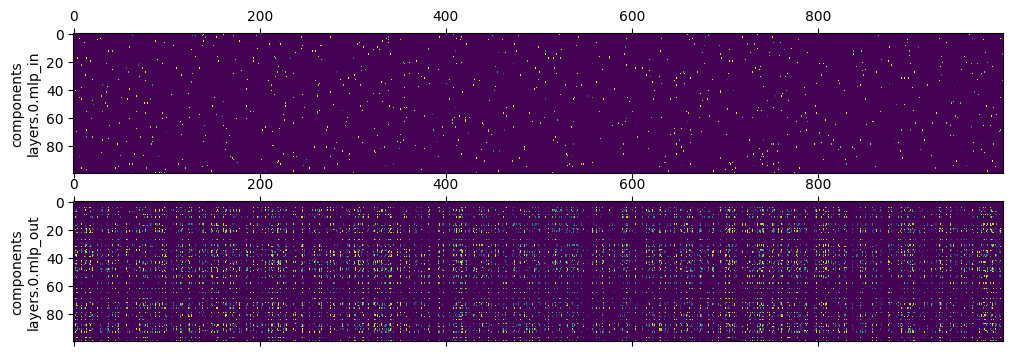

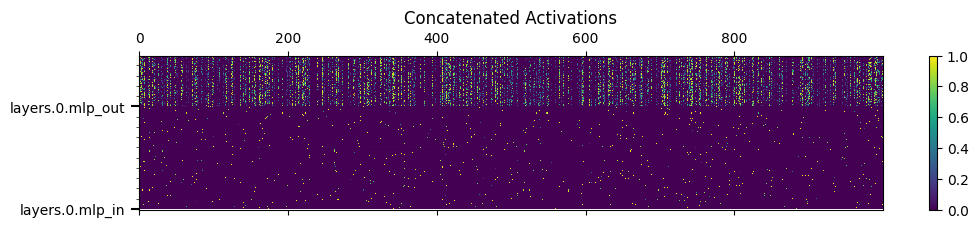

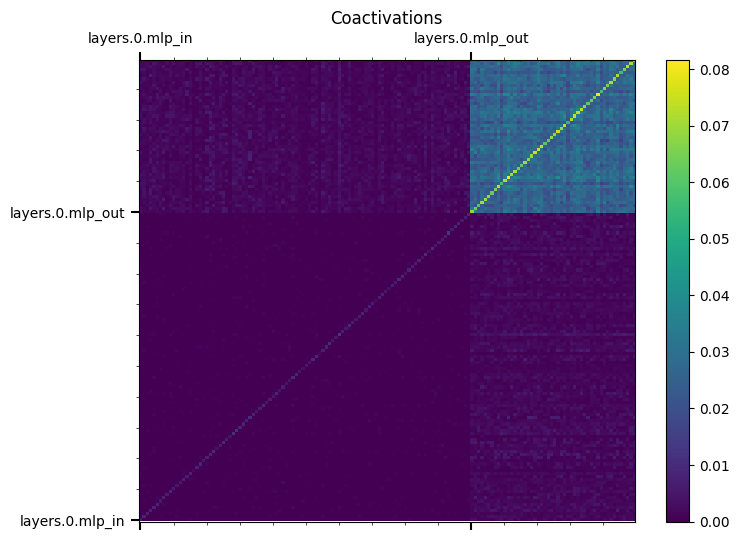

In [7]:
coa = process_activations(
	ci,
	filter_dead_threshold=0.1,
	plots=True,
);

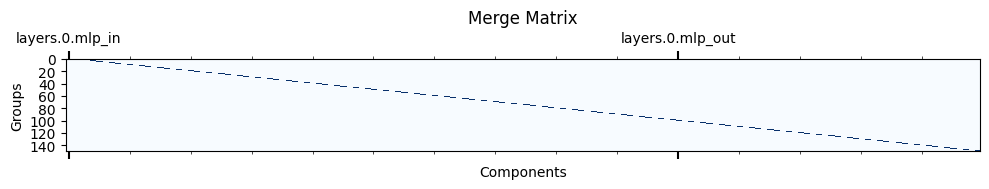

In [8]:
gm_ident = GroupMerge.identity(n_components=coa["n_components_alive"])
			
gm_ident.plot(figsize=(10, 2), component_labels=coa["labels"])

$$
	F_g := \frac{\alpha}{n}
	\Bigg[
		d(A(g)) \cdot Q^T 
		+ Q \cdot d(A(g))^T
		- \Big(
			R \mathbf{1}^T
			+ \mathbf{1} R^T + \alpha^{-1}
		\Big) 
		\odot A(g)
	\Bigg]
$$

/home/miv/projects/MATS/spd/spd/clustering/merge.py:104: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  diag @ ranks.T


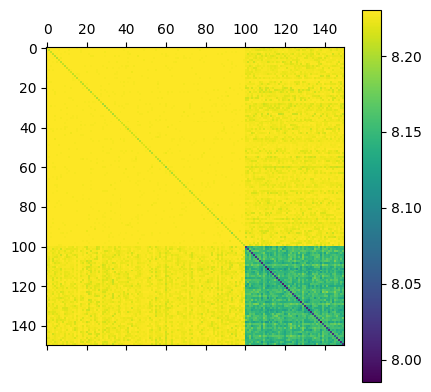

In [9]:
costs = compute_merge_costs(
	coact=coa['coactivations'],
	merges=gm_ident,
)
plt.matshow(costs.cpu(), cmap='viridis')
plt.colorbar()

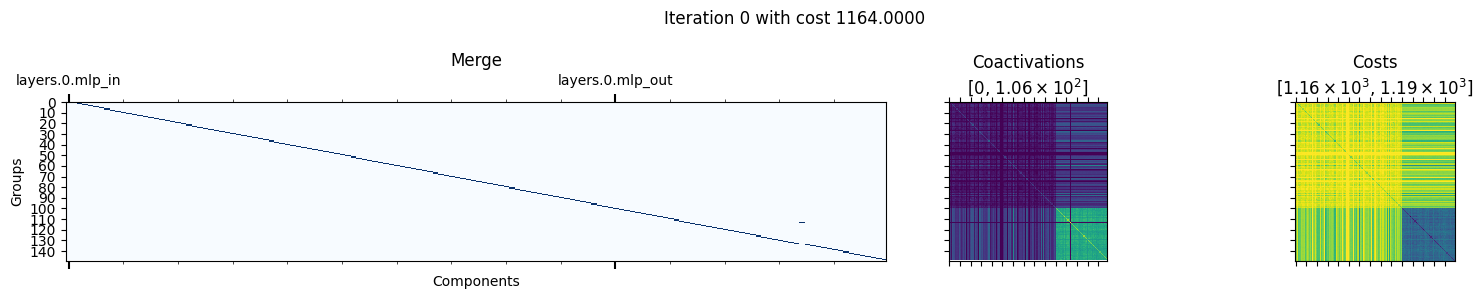

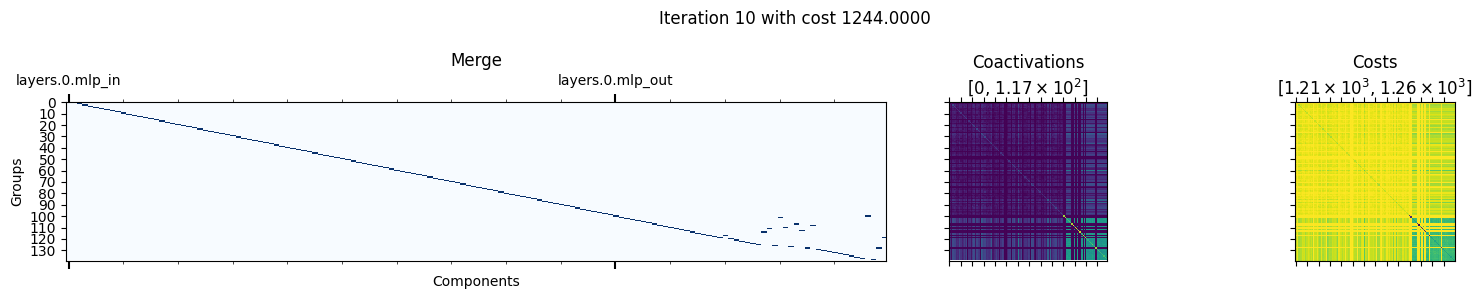

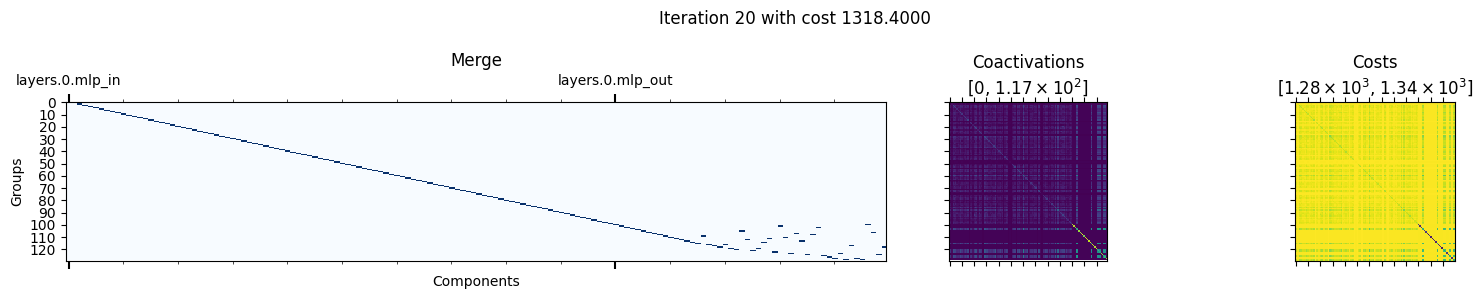

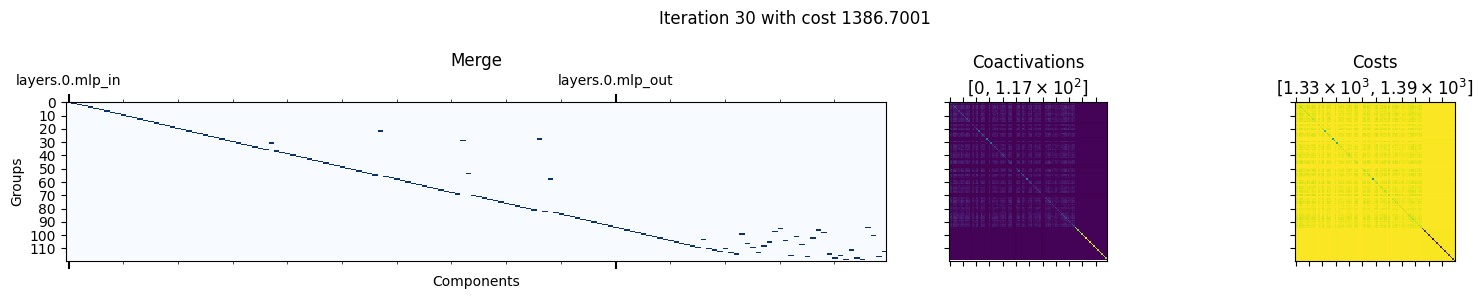

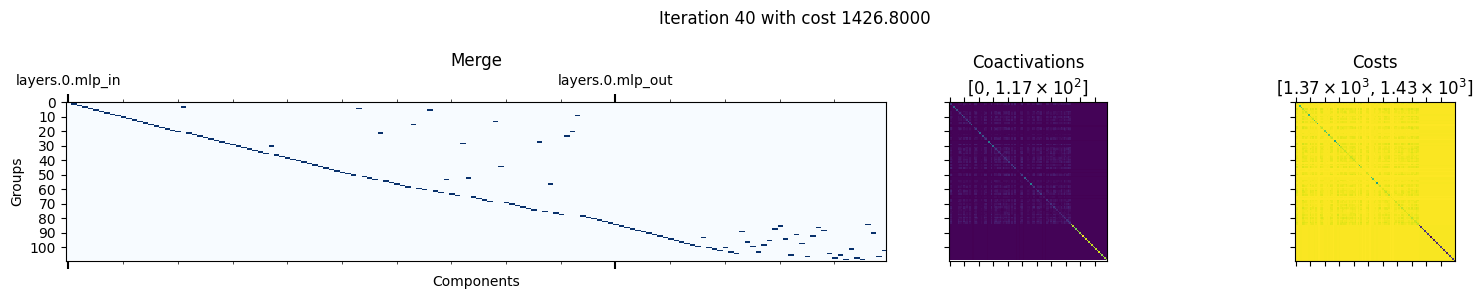

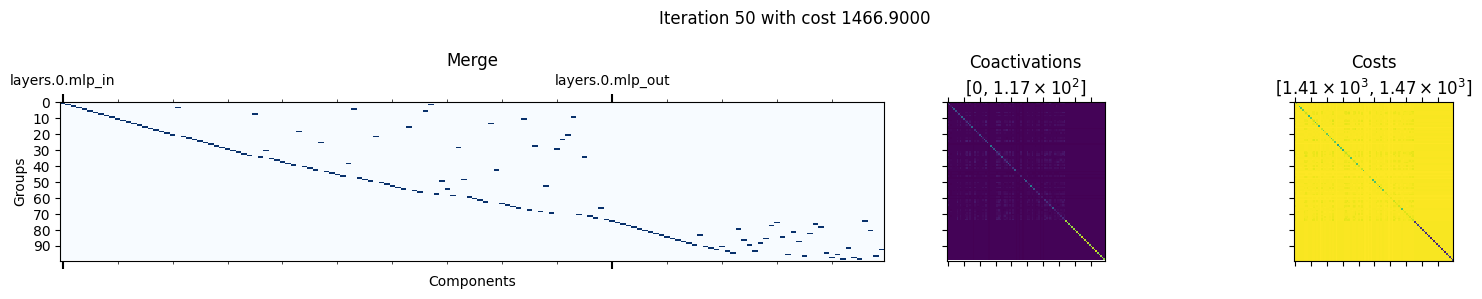

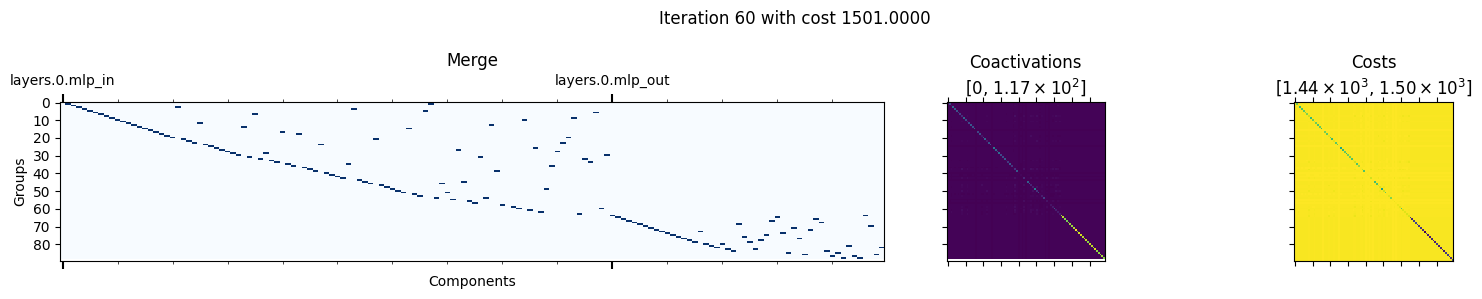

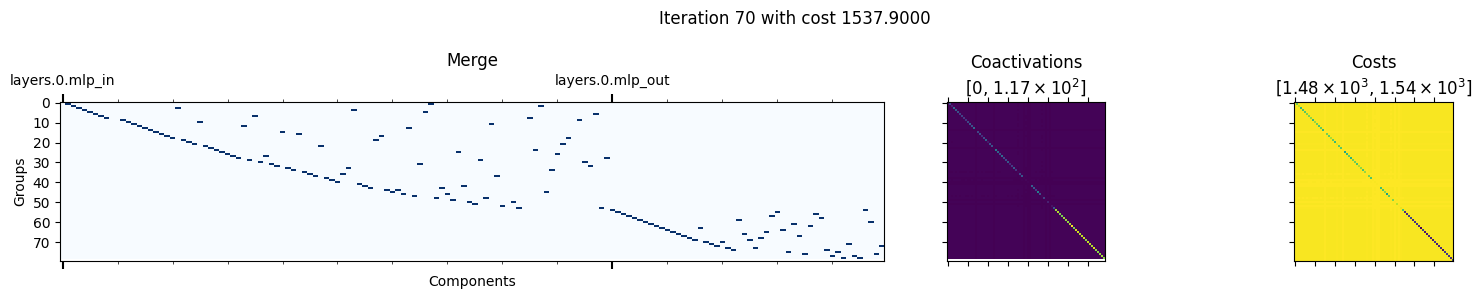

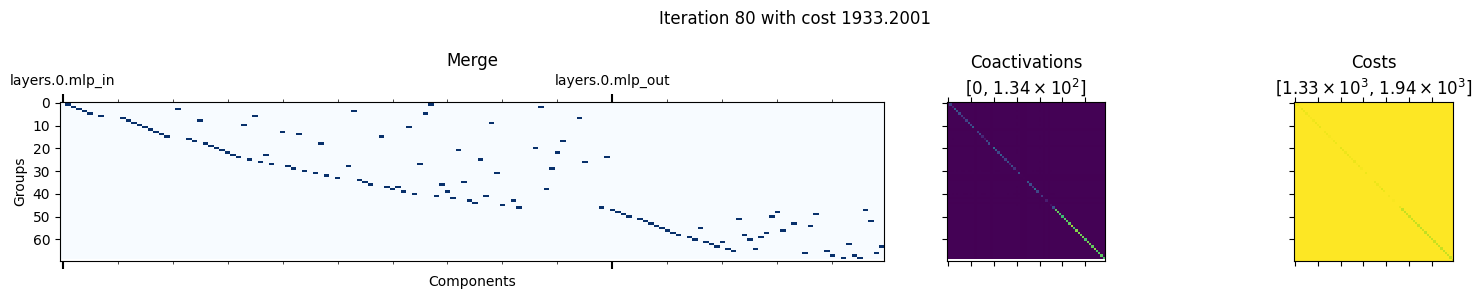

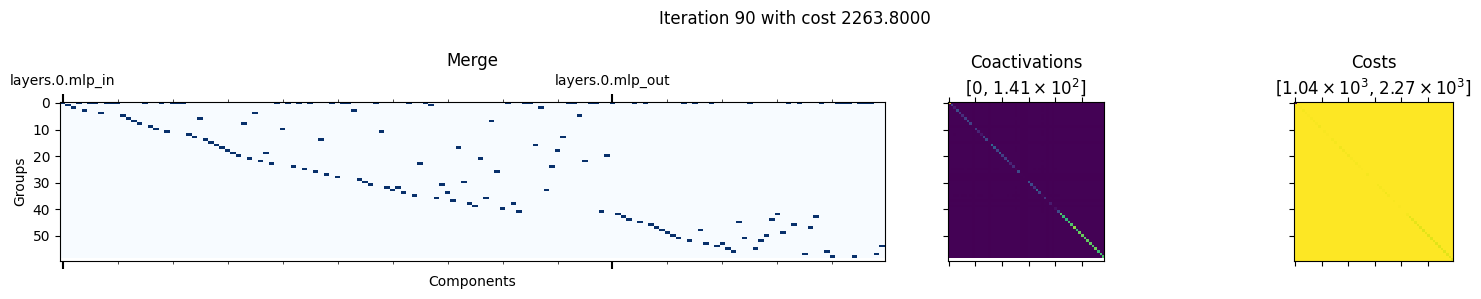

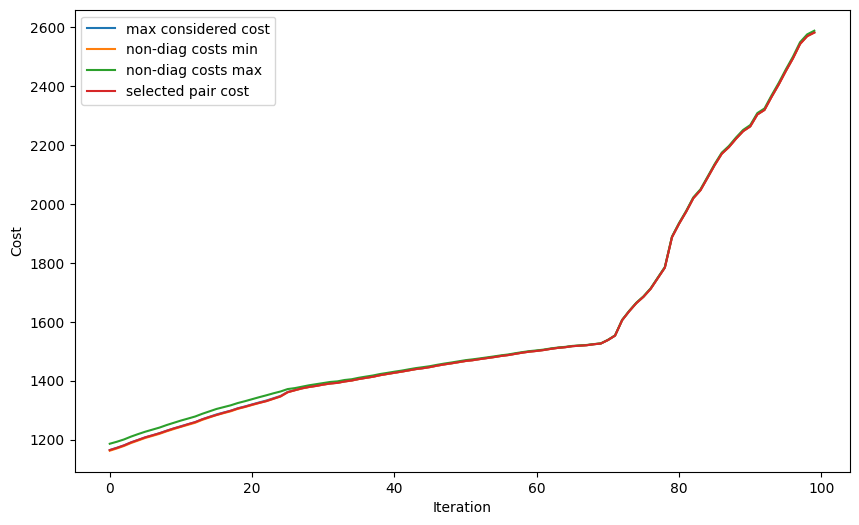

In [12]:
coact_bool = coa['coactivations'] > 0.002
merge_iteration(
	coact=coact_bool.float().T @ coact_bool.float(),
	activation_mask=coact_bool,
	check_threshold=0.1,
	# initial_merge=?,
	# alpha=0.001,
	rank_cost=lambda _: 1e-1,
	alpha=1e-1,
	iters=100,
	plot_every=10,
	plot_every_min=0,
	component_labels=coa["labels"],
	# plot_every=None,
)